In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import string
import nltk
import re
import random
import requests
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords, words
from io import BytesIO
from PIL import Image
from textblob import TextBlob
import os

In [3]:
data = pd.read_csv('labels.csv')

In [4]:
df = data.dropna()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6830 entries, 0 to 6991
Data columns (total 5 columns):
Unnamed: 0        6830 non-null int64
image_name        6830 non-null object
text_ocr          6830 non-null object
text_corrected    6830 non-null object
target            6830 non-null object
dtypes: int64(1), object(4)
memory usage: 320.2+ KB


In [6]:
df['target'].value_counts()

notoffensive        4058
slightoffensive     2157
hatefuloffensive     469
veryoffensive        146
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

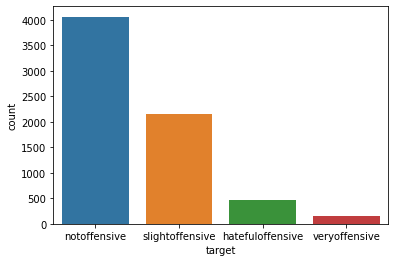

In [7]:
import seaborn as sns
sns.countplot(x="target", data = df)

In [8]:
df['message'] = df['text_corrected']

In [9]:
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import string 
from nltk.stem import WordNetLemmatizer

In [10]:
Tweet = []
Labels = []

for row in df["message"]:
    #tokenize words
    words = word_tokenize(row)
    #remove punctuations
    clean_words = [word.lower() for word in words if word not in set(string.punctuation)]
    #remove stop words
    english_stops = set(stopwords.words('english'))
    characters_to_remove = ["''",'``',"rt","https","’","“","”","\u200b","--","n't","'s","...","//t.c" ]
    clean_words = [word for word in clean_words if word not in english_stops]
    clean_words = [word for word in clean_words if word not in set(characters_to_remove)]
    #Lematise words
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_list = [wordnet_lemmatizer.lemmatize(word) for word in clean_words]
    Tweet.append(lemma_list)

In [11]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df['class']= label_encoder.fit_transform(df['target'])

df['class'].unique()

array([1, 2, 0, 3], dtype=int64)

In [68]:
X = df['message']
y = df['class']

In [69]:
# Extract Feature With CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(X) # Fit the Data

In [70]:
import pickle
pickle.dump(cv, open("model.pkl", "wb"))

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [67]:
from sklearn.metrics import accuracy_score

# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train) 
y_pred = dt.predict(X_test)

val1 = accuracy_score(y_test, y_pred)

In [17]:
val1

0.5080527086383602

# Voting CLassifier

In [52]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
clf1 = AdaBoostClassifier()
clf2 = RandomForestClassifier()

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2)], voting='soft')
eclf1.fit(X_train,y_train)

y_pred = eclf1.predict(X_test)

val2 = accuracy_score(y_test, y_pred)

In [53]:
val2

0.9978038067349927

# Deep Learning

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
import os
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.layers import LSTM


from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [21]:
import collections
import nltk
from sklearn import preprocessing
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorflow.keras import regularizers

In [22]:
#Setting parameters which will be used throughout
num_words = 15000  # Parameter indicating the number of words we'll put in the dictionary
val_size = 1000  # Size of the validation set
epochs = 20  # Number of epochs we usually start to train with
batch_size = 16  # Size of the batches used in the mini-batch gradient descent
#Taking only two columns since it's a sentiment analysis

In [23]:
#tweets conssits of every document as an array of tokenized words which are later appended to docs 
tweets=[word_tokenize(tweet) for tweet in df['message']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])

In [24]:
#stops included both the stopwords and punctuations
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
not_list = ["n't", "not", "no"]
stops.update(punctuations)
stops.update(not_list)

In [25]:
#to get the simple pos(part of speech) tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [26]:
#to get the pos tag for a word
from nltk import pos_tag
# now we are going to clean our data 
# we will remove stopwords and punctuations and lemmatize each document
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops or word.lower() in not_list:
            pos=pos_tag(word)
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1]))
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1
#docs=[ clean(doc) for doc in docs]      

In [27]:
df.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,target,message,class
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,notoffensive,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,1
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,notoffensive,The best of #10 YearChallenge! Completed in le...,1
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,notoffensive,Sam Thorne @Strippin ( Follow Follow Saw every...,1
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,notoffensive,10 Year Challenge - Sweet Dee Edition,1
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,slightoffensive,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,2


In [28]:
#taking variables to be used for train test split as X,y
X,Y=df['message'].values,pd.get_dummies(df['class'].values)

In [29]:
#using tokenizers to create the tokens having no of words=15000(num_words)
tk = Tokenizer(num_words=num_words,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
#Complete data is tokenized to vectors and padding is done using zeros to match its length to the largest text in the dataset.
tk.fit_on_texts(X)
X = tk.texts_to_sequences(X)
X = pad_sequences(X)
#print(X[:2])
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 6830 documents
15000 words in dictionary
Top 5 most common words are: [('the', 3112), ('you', 2459), ('a', 2066), ('i', 2012), ('to', 1845)]


In [30]:
import pickle
pickle.dump(tk,open('transform.pkl','wb'))
#files.download('transform2.pkl')

In [31]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# LSTM

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [36]:
embed_dim = 128 #dimension of the word embedding vector for each word in a sequence 
lstm_out = 196  #no of lstm layers
model = Sequential()
model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
#Adding dropout
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
#Adding a regularized dense layer
model.add(layers.Dense(32,kernel_regularizer=regularizers.l2(0.001),activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 192, 128)          1920000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                6304      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 2,181,236
Trainable params: 2,181,236
Non-trainable params: 0
_________________________________________________________________


In [38]:
#model trained on the training data and taking validation data into account to avoid overfitting for 4 epochs 
history1 = model.fit(X_train, Y_train, epochs = 5, batch_size=16,validation_data=(X_test, Y_test),verbose = 1)

Epoch 1/5
342/342 [==============================] - 194s 560ms/step - loss: 1.0313 - accuracy: 0.5917 - val_loss: 0.9781 - val_accuracy: 0.5754
Epoch 2/5
342/342 [==============================] - 213s 622ms/step - loss: 0.9761 - accuracy: 0.5988 - val_loss: 0.9933 - val_accuracy: 0.5754
Epoch 3/5
342/342 [==============================] - 218s 638ms/step - loss: 0.8488 - accuracy: 0.6288 - val_loss: 1.0894 - val_accuracy: 0.4985
Epoch 4/5
342/342 [==============================] - 217s 634ms/step - loss: 0.6471 - accuracy: 0.7399 - val_loss: 1.2805 - val_accuracy: 0.5110
Epoch 5/5
342/342 [==============================] - 216s 633ms/step - loss: 0.4762 - accuracy: 0.8318 - val_loss: 1.5360 - val_accuracy: 0.4780


In [58]:
val3 = history1.history['val_accuracy'][4]

# RNN

In [39]:
embed_dim = 128 #dimension of the word embedding vector for each word in a sequence 
lstm_out = 196  #no of lstm layers
model = Sequential()
model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
#Adding dropout
model.add(SimpleRNN(lstm_out, dropout=0.2, recurrent_dropout=0.2))
#Adding a regularized dense layer
model.add(layers.Dense(32,kernel_regularizer=regularizers.l2(0.001),activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 192, 128)          1920000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 196)               63700     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                6304      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
Total params: 1,990,136
Trainable params: 1,990,136
Non-trainable params: 0
_________________________________________________________________


In [40]:
#model trained on the training data and taking validation data into account to avoid overfitting for 4 epochs 
history2 = model.fit(X_train, Y_train, epochs = 5, batch_size=16,validation_data=(X_test, Y_test),verbose = 1)

Epoch 1/5
342/342 [==============================] - 45s 128ms/step - loss: 1.1003 - accuracy: 0.5719 - val_loss: 1.0186 - val_accuracy: 0.5754
Epoch 2/5
342/342 [==============================] - 43s 125ms/step - loss: 1.0275 - accuracy: 0.5986 - val_loss: 1.0033 - val_accuracy: 0.5754
Epoch 3/5
342/342 [==============================] - 43s 126ms/step - loss: 0.9977 - accuracy: 0.5990 - val_loss: 1.0010 - val_accuracy: 0.5754
Epoch 4/5
342/342 [==============================] - 43s 126ms/step - loss: 0.9560 - accuracy: 0.5985 - val_loss: 1.0229 - val_accuracy: 0.5754
Epoch 5/5
342/342 [==============================] - 43s 126ms/step - loss: 0.8789 - accuracy: 0.6076 - val_loss: 1.0970 - val_accuracy: 0.5476


In [59]:
val4 = history2.history['val_accuracy'][4]

# LSTM + GRU

In [41]:
embed_dim = 128 

In [42]:
model_hy=tf.keras.Sequential()

model_hy.add(tf.keras.layers.Input(shape=[100]))
model_hy.add(tf.keras.layers.Embedding(num_words,embed_dim,input_length=X_train.shape[1]))    

model_hy.add(tf.keras.layers.LSTM(200, return_sequences=True))
model_hy.add(tf.keras.layers.Dropout(0.5))

model_hy.add(tf.keras.layers.LSTM(200,return_sequences=True))
model_hy.add(tf.keras.layers.Dropout(0.5))

model_hy.add(tf.keras.layers.GRU(200))
model_hy.add(tf.keras.layers.Dropout(0.5))
          
model_hy.add(tf.keras.layers.Dense(256))
model_hy.add(tf.keras.layers.Dropout(0.5))

model_hy.add(tf.keras.layers.Dense(4,activation='sigmoid')) #output layer

In [43]:
model_hy.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 128)          1920000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 200)          263200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 200)          320800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
gru (GRU)                    (None, 200)               241200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)              

In [45]:
model_hy.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['accuracy'])

In [48]:
history3 = model_hy.fit(X_train, Y_train, epochs = 5, batch_size=2,validation_data=(X_test, Y_test),verbose = 1)

Epoch 1/5
171/171 [==============================] - 111s 634ms/step - loss: 0.9884 - accuracy: 0.5659 - val_loss: 0.9461 - val_accuracy: 0.5754
Epoch 2/5
171/171 [==============================] - 110s 642ms/step - loss: 0.9060 - accuracy: 0.5944 - val_loss: 0.6650 - val_accuracy: 0.7291
Epoch 3/5
171/171 [==============================] - 109s 641ms/step - loss: 0.5743 - accuracy: 0.7709 - val_loss: 0.2245 - val_accuracy: 0.9209
Epoch 4/5
171/171 [==============================] - 110s 643ms/step - loss: 0.2886 - accuracy: 0.8953 - val_loss: 0.1361 - val_accuracy: 0.9597
Epoch 5/5
171/171 [==============================] - 110s 646ms/step - loss: 0.1657 - accuracy: 0.9466 - val_loss: 0.0881 - val_accuracy: 0.9722


In [60]:
val5 = history3.history['val_accuracy'][4]

# Comparison

In [61]:
x=['DT','Voting','LSTM','RNN','LSTM+GRU']
y = [val1,val2,val3,val4,val5]

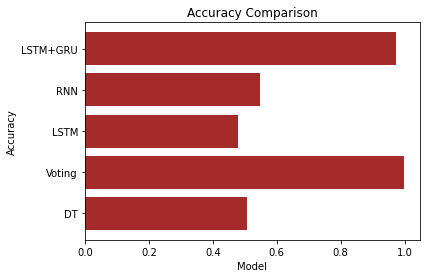

In [62]:
plt.barh(x,y, color='brown')
plt.xlabel('Model')
plt.ylabel("Accuracy")
plt.title('Accuracy Comparison')
plt.show()

In [73]:
import joblib
filename = 'model.sav'
joblib.dump(eclf1, filename)

['model.sav']

Prediction

In [74]:
import pickle
import numpy as np
import nltk
import joblib

In [76]:
cv = pickle.load(open("model.pkl", 'rb'))

model = joblib.load('model.sav')

In [136]:
import os
import easyocr
import cv2

In [148]:
IMAGE_PATH = "images/images/image_133.jpg"

In [149]:
reader = easyocr.Reader(['en'])
result = reader.readtext(IMAGE_PATH,paragraph="False")
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[[[[72, 8], [392, 8], [392, 80], [72, 80]], 'WITHOUT ME'],
 [[[24, 356], [436, 356], [436, 427], [24, 427]], 'IT"S JUST AWESO']]

In [150]:
var1 = result[0][1]

In [151]:
try:
    var2 = result[1][1]
    print(var2)
except IndexError:
    var2 = '!'
    print(var2)

IT"S JUST AWESO


In [152]:
var3 = " ".join([var1, var2])

In [153]:
var3

'WITHOUT ME IT"S JUST AWESO'

In [154]:
data = [var3]

In [155]:
vect = cv.transform(data).toarray()
my_prediction = model.predict(vect)
        
print(my_prediction[0])

2
